# Neural Networks for Data Science Applications
## Homework 1: Evaluating the calibration of a DL model

**Name**: *Braulio Villalobos-Quiros*

**Matricola**: *1999250*

Upload the completed notebook **before 14/11/2022 at 23:59** on the Google Classroom page.

In [1]:
#pip install tensorflow-transform
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
#import tensorflow_transform as tft 
import tensorflow_probability as tfp
# pip install tensorflow-transform

### Overview

The homework concerns training and evaluating the calibration of a neural network. It is divided into a small series of exercises: **the maximum mark (for the purpose of the exam) is 5**, but the total sum of points is 5.5, so you are allowed a margin of error. **Completing succesfully everything will result in a mark of 5+**.

🟥 The homework must be completed *using TensorFlow*. Do not use NumPy or anything else (with one exception in Exercise 5).

Below a brief description of the exercises; please read everything carefully at least once.

1.   **Exercise 1** (1 point): training a neural network on the provided dataset.
2.   **Exercise 2 and 3** (2 points): draw a *confidence histogram* and a *reliability diagram* (see instructions).
3.   **Exercise 4** (0.5 points): compute the *expected calibration error* (ECE).
3.   **Exercise 5** (1 point): implement the *multi-class focal loss* and re-check calibration.
4.   **Exercise 6** (1 point): implement a simple *conformal prediction* (CP) strategy (see instructions below).





## Data loading

The dataset we use is a well-known toy multiclass dataset concerning wine quality: https://archive.ics.uci.edu/ml/datasets/wine+Quality

We preprocess the original quality index into three classes (low, medium, and high quality), similarly to this notebook that you can check for more information about the dataset: https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises

In [3]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [4]:
def load_data():
  """ Load and preprocesses the wine dataset.
  Returns:
    - X_train, X_test, y_train, y_test [tf.Tensor]: train and test input/output matrices.
  """
  import pandas as pd
  from sklearn.model_selection import train_test_split
  
  data = pd.read_csv('winequality-white.csv', sep=';')
  data['quality_label'] = data.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 7 else 2)
  X, y = data.values[:, :-1], data.values[:, -1]
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
  return tf.constant(X_train), tf.constant(y_train), tf.constant(X_test), tf.constant(y_test)

In [5]:
X_train, y_train, X_test, y_test = load_data()

In [6]:
# Check some details about the dataset. You are free to add any additional pre-processing to understand it better.
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Number of classes: {tf.reduce_max(y_train) + 1}')

Shape of X_train: (3673, 12)
Shape of y_train: (3673,)
Number of classes: 3.0


In [7]:
#BVQ_done
tf.unique_with_counts(y_train,
                      out_idx=tf.dtypes.int32,
                      name=None)

UniqueWithCounts(y=<tf.Tensor: shape=(3,), dtype=float64, numpy=array([0., 1., 2.])>, idx=<tf.Tensor: shape=(3673,), dtype=int32, numpy=array([0, 1, 0, ..., 1, 2, 0], dtype=int32)>, count=<tf.Tensor: shape=(3,), dtype=int32, numpy=array([1230, 2308,  135], dtype=int32)>)

*************
We appreciate 2 important things: 

* Confirm in another way that we're dealing with a multiclass classification problem as we have 3 classes.
* The training examples aren't necessarily balanced as we have almost twice   of the training examples of class 2 (2308) than those from class 1 (1230). Additionally, we have just 135 training observations from class 3. This unbalanced number of observations **might** translate into an issue that we must address. 
*************

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Comments are appreciated.

In [ ]:
# TODO: define a suitable neural network.
net = 

SyntaxError: ignored

### Simplest Network 

In [ ]:
# BVQ_Done

# Simplest neural network possible

#from tensorflow import keras

#net = keras.Sequential()
#net.add(keras.layers.Dense(50, activation=keras.activations.relu))
#net.add(keras.layers.Dense(3))

#BVQ_Done
#net(X_train).shape

#BVQ_Done
#ypred = net(X_train)

#BVQ_Done
#tf.reduce_mean(
#    keras.losses.sparse_categorical_crossentropy(y_train, ypred, from_logits=True)
#)

#BVQ_Done
#keras.metrics.SparseCategoricalAccuracy()(y_train, ypred)

#BVQ_Done
#cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
#accuracy = keras.metrics.SparseCategoricalAccuracy()
#optimizer = keras.optimizers.SGD(learning_rate=0.1)


#BVQ_Done
#losses = []
#accuracies = []

# for i in range(5000):

#     with tf.GradientTape() as tape:

#         ypred = net(X_train)
#         loss = cross_entropy(y_train, ypred)

#     # --> First difference: we differentiate w.r.t. all variables.
#     gradients = tape.gradient(loss, net.trainable_variables)

#     # --> We use the optimizer to apply the gradients.
#     optimizer.apply_gradients(zip(gradients, net.trainable_variables))

#     losses.append(loss.numpy())
#     accuracies.append(accuracy(y_train, ypred).numpy())

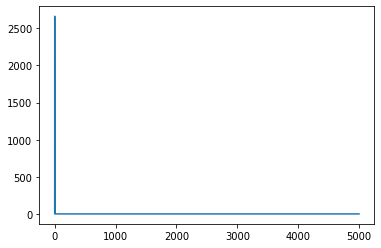

In [ ]:
#BVQ_Done
plt.plot(losses)

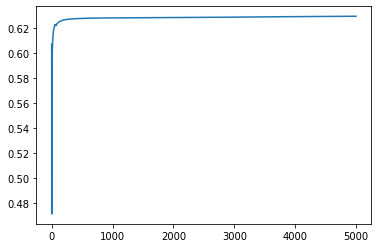

In [ ]:
#BVQ_Done
plt.plot(accuracies)

### 2nd Model - Using more already built-up functions

In [8]:
#BVQ_Done

#Since the last network attains a quite significantly high accuracy
#We recreate it but using the already built-up functions
#In order to have a more organized code
from tensorflow import keras

# We set a random seed for replication purporse, although it can be removed
#tf.random.set_seed(26)

# We define the model 
net = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = keras.activations.relu),
    tf.keras.layers.Dense(50, activation = keras.activations.relu),
    tf.keras.layers.Dense(3, activation = keras.activations.softmax)
])

net.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01),
            metrics = tf.keras.metrics.SparseCategoricalAccuracy()
)

In [9]:
history = net.fit(X_train, y_train, epochs=1000, verbose = 0)

In [10]:
history

In [11]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1300      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 6,503
Trainable params: 6,503
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Check the accuracy of our model
loss, accuracy = net.evaluate(X_test, y_test)
print(f"Model loss on test set: {loss}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

39/39 [==============================] - 0s 2ms/step - loss: 0.2254 - sparse_categorical_accuracy: 0.8963
Model loss on test set: 0.2253674566745758
Model accuracy on test set: 89.63%


In [13]:
accuracy

0.8963265419006348

In [14]:
net.evaluate(X_test, y_test)

39/39 [==============================] - 0s 2ms/step - loss: 0.2254 - sparse_categorical_accuracy: 0.8963


[0.2253674566745758, 0.8963265419006348]

In [15]:
my_vect = net.predict(X_test)

39/39 [==============================] - 0s 2ms/step


In [16]:
my_vect

array([[3.1558510e-08, 9.8152161e-01, 1.8478330e-02],
       [9.2488051e-10, 9.6451288e-01, 3.5487067e-02],
       [7.9603100e-01, 1.9841193e-01, 5.5570882e-03],
       ...,
       [1.0433360e-07, 9.9838555e-01, 1.6142963e-03],
       [4.3122366e-01, 5.6722569e-01, 1.5506680e-03],
       [1.0956818e-03, 9.9535036e-01, 3.5539418e-03]], dtype=float32)

In [17]:
def gather_indexes_f(y_test_inp, predictions):
  first = tf.cast(tf.range(0,y_test_inp.shape), tf.int32)
  second = tf.cast(tf.constant(tf.argmax(predictions,1)), tf.int32)

  return tf.stack([first, second], axis=1)

def pred_confidence(predictions, max_indexes):
  return tf.gather_nd(predictions,max_indexes)

In [18]:
uyuy = gather_indexes_f(y_test, my_vect)

In [19]:
piou = pred_confidence(my_vect,uyuy)
piou

<tf.Tensor: shape=(1225,), dtype=float32, numpy=
array([0.9815216 , 0.9645129 , 0.796031  , ..., 0.99838555, 0.5672257 ,
       0.99535036], dtype=float32)>

In [20]:
avg_confidence = np.mean(piou)
avg_confidence

0.8906553

In [21]:
num_bins = 10
bins = tf.linspace(start=0.0, stop=1.0, num=num_bins)
print(bins)

tf.Tensor(
[0.         0.11111111 0.22222222 0.33333334 0.44444445 0.5555556
 0.6666667  0.7777778  0.8888889  1.        ], shape=(10,), dtype=float32)


Text(0.9006552791595459, 1, 'confidence')

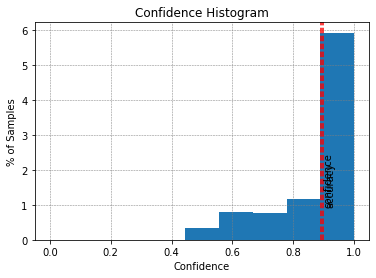

In [22]:
plt.hist(piou,bins, histtype ='bar', density = True)
plt.title("Confidence Histogram")
plt.xlabel("Confidence")
plt.ylabel("% of Samples")
plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")
plt.axvline(x=accuracy,color='red', linestyle='--')
plt.annotate("accuracy",rotation=90,xy=(accuracy+0.01, 1))
plt.axvline(x=avg_confidence,color='red', linestyle='--')
plt.annotate("confidence",rotation=90,xy=(avg_confidence+0.01, 1))

# Reliability Plots

In [37]:
import tensorflow as tf
#1) Needed inputs: 
num_bins = 10
#2) True labels that correspond to the y_test
#3) Predicted labels
pred_labels = tf.argmax(my_vect, axis=-1) 

#4) Confidence array which correspond to the highest output probability for each prediction

def reliability_preprocess(true_labels, predicted_labels, confidence_array, num_bins = 10):

  bin_size = 1.0/num_bins
  bins = np.linspace(0.0,1.0,num_bins)

  #indices = np.digitize(confidence_array, bins, right= True)
  layer = tf.keras.layers.Discretization(bin_boundaries=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
  indices = layer(confidence_array)

  bin_accuracies = np.zeros(num_bins)#, dtype=np.float) #array for avg accuracies in each bin
  bin_confidences = np.zeros(num_bins)#, dtype=np.float) #array for avg confidences in each bin
  bin_counts = np.zeros(num_bins)#dtype=np.int) #array counting how many predictions fall on each bin


  for b in range(num_bins):
    chosen_bin = tf.constant(np.where(indices == b + 1)[0], dtype=tf.int64) #selects all observations that belong to the same bin

    #Clause to avoid nan in vectors
    if len(chosen_bin)>0:
      #compute average accuracy of the bin by comparing the true and predicted labels
      bin_accuracies[b] = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.gather(true_labels,chosen_bin),tf.int64),tf.gather(predicted_labels,chosen_bin)), tf.float32))
    
      #compute average confidence of the bin
      bin_confidences[b] = tf.reduce_mean(tf.gather(confidence_array,chosen_bin))
    
      #count how many elements are within each bin
      bin_counts[b] = len(chosen_bin)

  avg_network_accuracy = np.mean(bin_accuracies)
  avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
  avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

  return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             #"expected_calibration_error": ece,
             #"max_calibration_error": mce 
          }

In [38]:
xxx = reliability_preprocess(y_test, pred_labels, piou, num_bins = 10)

In [39]:
xxx

{'accuracies': array([0.        , 0.        , 0.        , 1.        , 0.50617284,
        0.69      , 0.7589286 , 0.84090906, 0.98998749, 0.        ]),
 'confidences': array([0.        , 0.        , 0.        , 0.49890971, 0.54951334,
        0.64876229, 0.75838512, 0.83965164, 0.98297095, 0.        ]),
 'counts': array([  0.,   0.,   0.,   1.,  81., 100., 112., 132., 799.,   0.]),
 'bins': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 'avg_accuracy': 0.8963265349427048,
 'avg_confidence': 0.8906552334221042}

In [36]:
ind = np.arange(0,1,0.1)
ind

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

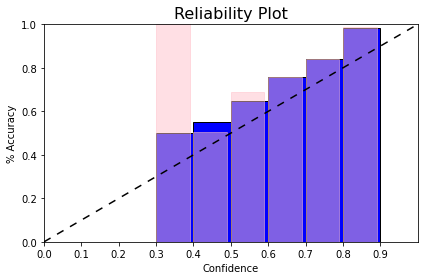

In [40]:
a = xxx['confidences']
b = xxx['accuracies']
ind = np.arange(0,1,0.1)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=ind, height=a, width = 0.1, align='edge', color = "blue", edgecolor= 'black')
ax.bar(x=ind, height=b, width=0.09,  align='edge', color = "pink", alpha = 0.5, edgecolor= 'pink')
#ax.axline((1, 1), slope=1)
plt.axline((0, 0), slope=1, color="black", linestyle=(0, (5, 5)))
#ident = [0.0, 1.0]
#plt.plot(ident,ident)
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)

plt.xticks(ind)
plt.title("Reliability Plot", size = 16)
plt.xlabel("Confidence")
plt.ylabel("% Accuracy")

plt.tight_layout()
plt.show()

Text(0.9006552791595459, 1, 'confidence')

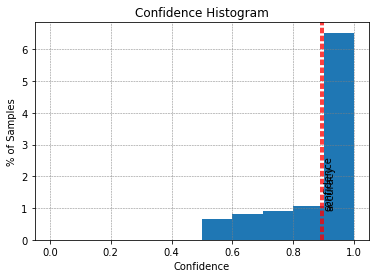

In [27]:
plt.hist(piou,xxx['bins'], histtype ='bar', density = True)
plt.title("Confidence Histogram")
plt.xlabel("Confidence")
plt.ylabel("% of Samples")
plt.grid(True, color = "grey", linewidth = "0.5", linestyle = "--")
plt.axvline(x=xxx['avg_accuracy'],color='red', linestyle='--')
plt.annotate("accuracy",rotation=90,xy=(accuracy+0.01, 1))
plt.axvline(x=xxx['avg_confidence'],color='red', linestyle='--')
plt.annotate("confidence",rotation=90,xy=(avg_confidence+0.01, 1))

In [ ]:
num_bins = 10
#2) True labels that correspond to the y_test
#3) Predicted labels
pred_labels = tf.argmax(my_vect, axis=-1) 

bin_size = 1.0/num_bins
bins = np.linspace(0.0,1.0,num_bins+1)

#indices = np.digitize(piou, bins, right= True)
layer = tf.keras.layers.Discretization(bin_boundaries=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
indices = layer(piou)

bin_accuracies = np.zeros(num_bins)#, dtype=np.float) #array for avg accuracies in each bin
bin_confidences = np.zeros(num_bins)#, dtype=np.float) #array for avg confidences in each bin
bin_counts = np.zeros(num_bins)#dtype=np.int) #array counting how many predictions fall on each bin

b = 2 
chosen_bin = tf.constant(np.where(indices == b + 1)[0], dtype=tf.int64)
chosen_bin

#a= tf.cast(tf.gather(y_test,chosen_bin),tf.int64)
#b= tf.gather(pred_labels,chosen_bin)
#tf.reduce_mean(tf.cast(tf.equal(a,b), tf.float32))
if len(chosen_bin)>0:
  bin_accuracies[b] = tf.reduce_mean(tf.cast(tf.equal(tf.cast(tf.gather(y_test,chosen_bin),tf.int64),tf.gather(pred_labels,chosen_bin)), tf.float32))
#len(tf.gather(y_test,chosen_bin)), len(tf.gather(pred_labels,chosen_bin))

In [ ]:
a = np.array([[0,0.1],[0.1,0.2]])
a

array([[0. , 0.1],
       [0.1, 0.2]])

Text(0.5, 1.0, 'Net Model with SGD - Training Phase')

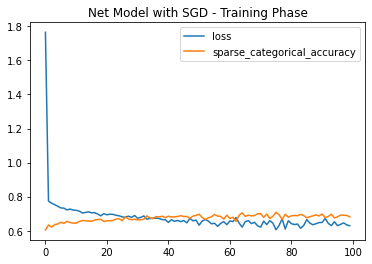

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.title("Net Model with SGD - Training Phase")

In [ ]:
#BVQ_Done

#Since the last network attains a quite significantly high accuracy
#We recreate it but using the already built-up functions
#In order to have a more organized code
from tensorflow import keras

# We set a random seed for replication purporse, although it can be removed
#tf.random.set_seed(26)

# We define the model 
net_adam = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation = keras.activations.relu),
    tf.keras.layers.Dense(50, activation = keras.activations.relu),
    tf.keras.layers.Dense(3, activation = keras.activations.softmax)
])

net_adam.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(),
            metrics = tf.keras.metrics.SparseCategoricalAccuracy()
)

In [ ]:
history_adam = net_adam.fit(X_train, y_train, epochs=1000)

Text(0.5, 1.0, 'Net Model with Adam Optimizer - Training Phase')

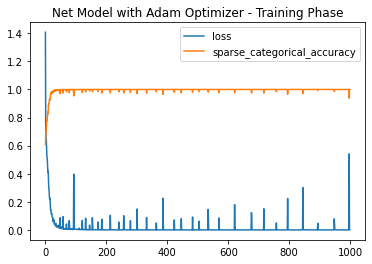

In [ ]:
pd.DataFrame(history_adam.history).plot()
plt.title("Net Model with Adam Optimizer - Training Phase")

In [ ]:
# TODO: train the neural network.

In [ ]:
# TODO: test the neural network and print the result on screen.


### Exercise 2: Confidence histogram of the network (1 point)

🟥 Before starting, read carefully at least Sections 1 and 2 of the following paper: [On the calibration of modern neural networks](https://arxiv.org/abs/1706.04599) (which we also discussed in class). We will refer to the paper as (Guo et al., 2017).

The purpose of this exercise is to replicate a confidence histogram *computed over the test set*, which is Fig. 1 in (Guo et al., 2017), top-left figure. The plot should include:
1. The distribution of the network's confidence (corresponding to **the highest output probability**);
2. The average accuracy of the network;
3. The average confidence of the network.

✅ **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.

In [ ]:
# To start: this is the number of bins for the histogram and the corresponding values. You are free to modify the number of bins.
num_bins = 10
bins = tf.linspace(start=0.0, stop=1.0, num=num_bins+1)
print(bins)

NameError: ignored

In [ ]:
# TODO: plot the confidence histogram.

### Exercise 3: Reliability diagrams (1 point)

This is similar to exercise 2, but you need to plot a **reliability diagram**, which is the bottom-left figure in Fig. 1 from (Guo et al., 2017). For this figure you need:

1. The histogram of the average accuracy of the network for each bin.
2. A superimposed histogram of the average confidence for each bin.
3. A diagonal line showing perfect calibration.

☝ **Hint**: the `Discretization` layer from TF may be useful: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Discretization

🟩 **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.


In [ ]:
input = np.array([[-1.5, 1.0, 3.4, .5], [0.0, 3.0, 1.3, 0.0]])
layer = tf.keras.layers.Discretization(bin_boundaries=[0., 1., 2.])
layer(input)

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[0, 2, 3, 1],
       [1, 3, 2, 1]])>

In [ ]:
# TODO: plot the reliability diagram.

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what does the previous diagrams tell you about the calibration of the neural network?

*Write your answer here.*

### Exercise 4: Expected calibration error, ECE (0.5 points)

For this exercise, you need to compute and print on screen the ECE, which is Eq. (3) from (Guo et al., 2017).

☝ **Hint(s)**: you should have computed almost everything already for Exercise 3. If you have NaN issues, you may want to check for empty bins.

🟩 **Completion requirement**: print the ECE.

In [ ]:
# TODO: compute and print the ECE for the network.

### Exercise 5: Calibrating with the focal loss (1 point)

🟥 Before proceeding, read carefully the following paper: [Calibrating Deep Neural Networks using Focal Loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). We'll refer to it as (Mukhoti et al., 2020).

The task of this exercise is to train again the neural network from before, using the Focal Loss (Section 4 in (Mukhoti et al., 2020)) instead of the cross-entropy:

\begin{equation}
L(y, \hat{y}) = - (1-\hat{y}_c)^\gamma \log \hat{y}_c
\end{equation}

where $\hat{y}$ is the vector of predictions from the network, $c$ is the index of the correct class ($y_c == 1$), $\gamma > 0$ is a hyper-parameter. For $\gamma=0$, this reduces to the cross-entropy.

☝ In order to implement a new loss function in TF, you need to subclass [tf.keras.losses.Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss). Read carefully the link.

🟩 **Completion requirement**: complete the `FocalLoss` implementation below. Instantiate a new network, train with the new focal loss, and check the resulting confidence histogram, reliability diagram, and ECE.


In [ ]:
class FocalLoss(tf.keras.losses.Loss):
  # TODO: complete implementation

In [ ]:
# TODO: Train a second neural network with the FocalLoss object.

In [ ]:
# TODO: plot confidence histogram, reliability diagram, and print the ECE of the new network.

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what can you tell about the calibration of this second neural network?

*Write your answer here.*

### Exercise 6: Conformal prediction (1 point)

🟥 Before proceeding, read **Section 1** from the following paper: [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511). We'll refer to it as (Angelopoulos and Bates, 2021). Note that this material *was not covered in class*.

CP can be understood as an alternative approach to calibration to quantify uncertainty of a model. In CP we take a trained classifier $f(x)$, and we transform it to a set-classifier, i.e., a classifier that outputs a set $\mathcal{C}(x)$ of possible classes. The set is guaranteed to satisfy:

\begin{equation}
P(y \in \mathcal{C}(x)) \ge 1 - \alpha
\end{equation}

where $\alpha$ is a hyper-parameter called the **error rate**, i.e., the probability that the correct class is inside the set is $1-\alpha$. For the purpose of this exercise, you need to implement a simple CP procedure which is described in Fig. 2 of (Angelopoulos and Bates, 2021).

☝ **Hints**: In practice, you would need a separate validation set. For the purpose of this exercise, you can use the previously defined test set for everything. For computing the **quantile**, you are allowed to use NumPy or TensorFlow Probability.

🟩 **Completion requirement**: Replicate the pseudocode from Fig. 2 of (Angelopoulos and Bates, 2021) in TF and apply it on the trained neural network. Plot a histogram showing the distribution of the sizes of the output sets, when the network is run on the entire test set.

In [ ]:
# Implement the CP procedure

In [ ]:
# Plot a histogram of the size of the output set (e.g., check "Set size" on page 12 of (Angelopoulos and Bates, 2021)).

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 14/11/2022 23:59** on the Google Classrom page.

### References

[1] Guo, C., Pleiss, G., Sun, Y. and Weinberger, K.Q., 2017. [On calibration of modern neural networks](https://arxiv.org/abs/1706.04599). In *ICML* (pp. 1321-1330). PMLR.

[2] Mukhoti, J., Kulharia, V., Sanyal, A., Golodetz, S., Torr, P. and Dokania, P., 2020. [Calibrating deep neural networks using focal loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). In *Advances in Neural Information Processing Systems*, 33, pp. 15288-15299.

[3] Angelopoulos, A.N. and Bates, S., 2021. [A gentle introduction to conformal prediction and distribution-free uncertainty quantification](https://arxiv.org/abs/2107.07511). *arXiv preprint arXiv:2107.07511*.